# Capital Bike Share Project

### Index
1.  [Exploratory Data Analysis](#1)<br>
2.  [headline2](#2)<br>
3.  [headline3](#3)<br>
4.  [headline4](#4)<br>
5.  [headline5](#5)<br>

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)


In [18]:
# load data

df = pd.read_csv('CBS_2021-2023_Full.csv.', sep=',', header=0, low_memory=False).copy()
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member
1,629E059504606547,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111.0,NaN,NaN,38.917193,-77.025894,38.960000,-77.020000,casual
2,E74069873161EE33,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member
3,91F95E512CABC46A,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member
4,DA46A05139C0EA2F,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,31651.0,14th & Newton St NW,31649.0,38.931322,-77.028247,38.931991,-77.032956,member


# 1: Exploratory Data Analysis<a id="1"></a>

In [19]:
df.shape

(10693997, 13)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693997 entries, 0 to 10693996
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 1.0+ GB


In [21]:
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      811282
end_station_id        811282
start_lat                  2
start_lng                  2
end_lat                16765
end_lng                16765
member_casual              0
dtype: int64

* the nan values at station_name and station_id columns are likely to be the bikes which werent picked to a station or from a station 
* but 2 rows with no start_lat or start_long value should be removed.

In [22]:
df = df.dropna(subset=['start_lat', 'start_lng'])
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      811282
end_station_id        811282
start_lat                  0
start_lng                  0
end_lat                16763
end_lng                16763
member_casual              0
dtype: int64

In [23]:
# check for duplicates
df.duplicated().sum()

0

In [24]:
# drop ride_id columns since I can use index for each rides
df = df.drop(columns=['ride_id'])

In [25]:
# check for duplicates again
df.duplicated().sum()

634

* We have 634 duplicated entries after removing the ride_id column. Since it is unlikely to have multiple rides at the exact same time with the exact same location details down to the second and meters, I am removing these duplicates.

In [26]:
#drop duplicates
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693361 entries, 0 to 10693360
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   rideable_type       object 
 1   started_at          object 
 2   ended_at            object 
 3   start_station_name  object 
 4   start_station_id    object 
 5   end_station_name    object 
 6   end_station_id      object 
 7   start_lat           float64
 8   start_lng           float64
 9   end_lat             float64
 10  end_lng             float64
 11  member_casual       object 
dtypes: float64(4), object(8)
memory usage: 979.0+ MB


In [27]:
df.duplicated().sum()

0

In [28]:
df['started_at'] = pd.to_datetime(df['started_at'])

df['ended_at'] = pd.to_datetime(df['ended_at'])

In [29]:
# create trip_duration column 

df['trip_duration'] = df['ended_at'] - df['started_at']
df['trip_duration'] = df['trip_duration'].dt.total_seconds() / 60
df['trip_duration'] = df['trip_duration'].round(0).astype(int)
df.head()

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member,25
1,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111.0,NaN,NaN,38.917193,-77.025894,38.960000,-77.020000,casual,16
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member,14
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member,6
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,31651.0,14th & Newton St NW,31649.0,38.931322,-77.028247,38.931991,-77.032956,member,3


* i will continue with reviewing each column and start with first colum rideable_type

In [30]:
df['rideable_type'].unique()

array(['classic_bike', 'electric_bike', 'docked_bike'], dtype=object)

In [31]:
df['rideable_type'].value_counts()

rideable_type
classic_bike     7709818
electric_bike    2444149
docked_bike       539394
Name: count, dtype: int64

* classic bikes are used for most of the rides with percentages follows:
* Classic Bike: 72.1%
* Electric Bike: 22.9%
* Docked Bike: 5.0%

In [32]:
df['rideable_type'] = df['rideable_type'].astype('category')

In [33]:
df['start_station_name'].nunique()

859

In [34]:
# change data type of station_id to integer

df['start_station_id'] = df['start_station_id'].astype(float).astype('Int64')

df.dtypes

rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id               Int64
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
trip_duration                  int32
dtype: object

In [35]:
df['start_station_id'].nunique()

773

* there is a difference between number of unique station names and station ids, which we need to resolve  
* The reason can be that a name has multiple id numbers

In [36]:
# Group by 'start_station_name' and get the unique 'start_station_id' for each station
start_station_ids = df.groupby('start_station_name')['start_station_id'].unique().reset_index()

# Add a new column to count the number of unique station IDs for each station name
start_station_ids['num_ids'] = start_station_ids['start_station_id'].apply(len)

# Filter the rows where there is more than one unique station ID for the same name
stations_with_multiple_ids = start_station_ids[start_station_ids['num_ids'] > 1].reset_index(drop=True)

stations_with_multiple_ids.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_station_name  4 non-null      object
 1   start_station_id    4 non-null      object
 2   num_ids             4 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes


In [37]:
stations_with_multiple_ids.head()

,start_station_name,start_station_id,num_ids
0,16th & Harvard St NW,"[31103, 31135]",2
1,Fairfax Dr & N Taylor St,"[31974, 31049]",2
2,Randle Circle & Minnesota Ave SE,"[31702, 31799]",2
3,S Wayne and 9th St,"[31980, 31971]",2


In [38]:
df[df['start_station_name'] == '16th & Harvard St NW']


,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
205,classic_bike,2021-01-01 06:52:40,2021-01-01 06:55:51,16th & Harvard St NW,31103,New Hampshire Ave & T St NW,31229.0,38.926088,-77.036536,38.915544,-77.038252,member,3
326,classic_bike,2021-01-01 09:34:03,2021-01-01 09:36:27,16th & Harvard St NW,31103,14th & Irving St NW,31124.0,38.926088,-77.036536,38.928552,-77.032224,member,2
383,classic_bike,2021-01-01 10:13:43,2021-01-01 10:26:01,16th & Harvard St NW,31103,16th & Harvard St NW,31103.0,38.926088,-77.036536,38.926088,-77.036536,member,12
476,classic_bike,2021-01-01 11:20:28,2021-01-01 11:35:13,16th & Harvard St NW,31103,18th & M St NW,31221.0,38.926088,-77.036536,38.905067,-77.041779,casual,15
608,classic_bike,2021-01-01 13:41:45,2021-01-01 13:49:12,16th & Harvard St NW,31103,16th & R St NW,31282.0,38.926088,-77.036536,38.912652,-77.036278,member,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10692907,electric_bike,2023-12-31 21:46:34,2023-12-31 21:46:52,16th & Harvard St NW,31135,NaN,NaN,38.926151,-77.036681,38.930000,-77.040000,casual,0
10692911,electric_bike,2023-12-31 21:48:35,2023-12-31 21:53:33,16th & Harvard St NW,31135,14th St & Spring Rd NW,31401.0,38.926107,-77.036656,38.937500,-77.032800,casual,5
10693041,electric_bike,2023-12-31 22:23:44,2023-12-31 22:24:53,16th & Harvard St NW,31135,NaN,NaN,38.926147,-77.036701,38.930000,-77.040000,member,1
10693117,electric_bike,2023-12-31 22:43:52,2023-12-31 22:48:44,16th & Harvard St NW,31135,14th & Belmont St NW,31119.0,38.926092,-77.036658,38.921074,-77.031887,member,5


* In this example station name: '16th & Harvard St NW' has 2 ids as follows: 31103 and 31135
* start_lat	and start_lng values are same till 3rd decimal point which assures that this name has duplicate ids


* I will review geo location columns on next steps but good to know decimal points accuracy at this moment:

    * 0 Decimal Places=	1.0	111 km
    * 1 Decimal Places=	0.1	11.1 km
    * 2 Decimal Places=	0.01	1.11 km
    * 3 Decimal Places=	0.001	111 m
    * 4 Decimal Places=	0.0001	11.1 m
    * 5 Decimal Places=	0.00001	1.11 m


In [39]:
df[df['start_station_name'] == 'Fairfax Dr & N Taylor St']

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
4625886,classic_bike,2022-07-26 16:59:34,2022-07-26 17:01:08,Fairfax Dr & N Taylor St,31974,Fairfax Dr & N Randolph St,31034.0,38.882425,-77.112754,38.882629,-77.109366,member,2
4633103,classic_bike,2022-07-27 08:38:01,2022-07-27 08:52:07,Fairfax Dr & N Taylor St,31974,Arlington Blvd & S George Mason Dr,31078.0,38.882425,-77.112754,38.869442,-77.104503,casual,14
4638014,classic_bike,2022-07-27 16:22:18,2022-07-27 16:27:03,Fairfax Dr & N Taylor St,31974,Glebe Rd & 11th St N,31038.0,38.882425,-77.112754,38.883921,-77.116817,member,5
4638258,electric_bike,2022-07-27 16:38:53,2022-07-27 16:43:02,Fairfax Dr & N Taylor St,31974,Fairfax Dr & Wilson Blvd,31023.0,38.882276,-77.112660,38.885801,-77.097745,member,4
4641901,classic_bike,2022-07-27 19:27:32,2022-07-27 19:28:48,Fairfax Dr & N Taylor St,31974,Ballston Metro / Stuart St & 9th St N,31037.0,38.882425,-77.112754,38.881044,-77.111768,member,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687471,classic_bike,2023-12-31 11:12:04,2023-12-31 11:19:48,Fairfax Dr & N Taylor St,31049,Washington-Liberty High School / N Stafford St...,31920.0,38.882425,-77.112754,38.888282,-77.111066,casual,8
10691058,classic_bike,2023-12-31 16:45:04,2023-12-31 18:18:35,Fairfax Dr & N Taylor St,31049,Fairfax Dr & N Taylor St,31049.0,38.882425,-77.112754,38.882425,-77.112754,casual,94
10691410,electric_bike,2023-12-31 17:21:40,2023-12-31 17:31:54,Fairfax Dr & N Taylor St,31049,Westover Library / Washington Blvd & N McKinle...,31921.0,38.882345,-77.112810,38.886048,-77.142317,member,10
10691636,classic_bike,2023-12-31 17:48:56,2023-12-31 17:51:39,Fairfax Dr & N Taylor St,31049,Glebe Rd & 11th St N,31038.0,38.882425,-77.112754,38.883921,-77.116817,member,3


* same situation for this station as well
* I will choose the first id number for each station name and update ids accordingly

In [40]:
# Update the 'start_station_id' for stations with multiple ids
df.loc[df['start_station_name'] == '16th & Harvard St NW', 'start_station_id'] = 31103
df.loc[df['start_station_name'] == 'Fairfax Dr & N Taylor St', 'start_station_id'] = 31974
df.loc[df['start_station_name'] == 'Randle Circle & Minnesota Ave SE', 'start_station_id'] = 31702
df.loc[df['start_station_name'] == 'S Wayne and 9th St', 'start_station_id'] = 31980


In [41]:
df[df['start_station_name'] == '16th & Harvard St NW']

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
205,classic_bike,2021-01-01 06:52:40,2021-01-01 06:55:51,16th & Harvard St NW,31103,New Hampshire Ave & T St NW,31229.0,38.926088,-77.036536,38.915544,-77.038252,member,3
326,classic_bike,2021-01-01 09:34:03,2021-01-01 09:36:27,16th & Harvard St NW,31103,14th & Irving St NW,31124.0,38.926088,-77.036536,38.928552,-77.032224,member,2
383,classic_bike,2021-01-01 10:13:43,2021-01-01 10:26:01,16th & Harvard St NW,31103,16th & Harvard St NW,31103.0,38.926088,-77.036536,38.926088,-77.036536,member,12
476,classic_bike,2021-01-01 11:20:28,2021-01-01 11:35:13,16th & Harvard St NW,31103,18th & M St NW,31221.0,38.926088,-77.036536,38.905067,-77.041779,casual,15
608,classic_bike,2021-01-01 13:41:45,2021-01-01 13:49:12,16th & Harvard St NW,31103,16th & R St NW,31282.0,38.926088,-77.036536,38.912652,-77.036278,member,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10692907,electric_bike,2023-12-31 21:46:34,2023-12-31 21:46:52,16th & Harvard St NW,31103,NaN,NaN,38.926151,-77.036681,38.930000,-77.040000,casual,0
10692911,electric_bike,2023-12-31 21:48:35,2023-12-31 21:53:33,16th & Harvard St NW,31103,14th St & Spring Rd NW,31401.0,38.926107,-77.036656,38.937500,-77.032800,casual,5
10693041,electric_bike,2023-12-31 22:23:44,2023-12-31 22:24:53,16th & Harvard St NW,31103,NaN,NaN,38.926147,-77.036701,38.930000,-77.040000,member,1
10693117,electric_bike,2023-12-31 22:43:52,2023-12-31 22:48:44,16th & Harvard St NW,31103,14th & Belmont St NW,31119.0,38.926092,-77.036658,38.921074,-77.031887,member,5


In [42]:
df['start_station_id'].nunique()

771

In [43]:
df['start_station_name'].nunique()

859

In [44]:
# Group by 'start_station_name' and get the unique 'start_station_id' for each station
start_station_ids = df.groupby('start_station_name')['start_station_id'].unique().reset_index()

# Add a new column to count the number of unique station IDs for each station name
start_station_ids['num_ids'] = start_station_ids['start_station_id'].apply(len)

# Filter the rows where there is more than one unique station ID for the same name
stations_with_multiple_ids = start_station_ids[start_station_ids['num_ids'] > 1].reset_index(drop=True)

stations_with_multiple_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_station_name  0 non-null      object
 1   start_station_id    0 non-null      object
 2   num_ids             0 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ bytes


* number of unique values for start names and ids did not change so much
* this indicates a similar issue on the start station id column side, which is a unique id may have multiple names 

In [45]:
# Group by 'start_station_id' and get the unique 'start_station_name' for each ID
station_names = df.groupby('start_station_id')['start_station_name'].unique().reset_index()

# Add a new column to count the number of unique station names for each station ID
station_names['num_names'] = station_names['start_station_name'].apply(len)

# Filter the rows where there is more than one unique station name for the same ID
ids_with_multiple_names = station_names[station_names['num_names'] > 1].reset_index(drop=True)

ids_with_multiple_names.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_station_id    83 non-null     Int64 
 1   start_station_name  83 non-null     object
 2   num_names           83 non-null     int64 
dtypes: Int64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [46]:
ids_with_multiple_names.head()

,start_station_id,start_station_name,num_names
0,31006,"[Army Navy Dr & S Joyce St, Pentagon Row Plaza...",2
1,31014,"[Lynn St & 19th St North, 19th St N & Ft Myer Dr]",2
2,31015,"[Rosslyn Metro / Wilson Blvd & Ft Myer Dr, Wil...",2
3,31027,"[Key Blvd & N Quinn St, Wilson Blvd & N Quinn St]",2
4,31030,"[Lee Hwy & N Adams St, Langston Blvd & N Adams...",2


In [47]:
df[df['start_station_id'] == 31030]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
549,electric_bike,2021-01-01 12:48:18,2021-01-01 13:09:00,Lee Hwy & N Adams St,31030,Columbia Pike & S Oakland St,31058.0,38.895969,-77.089021,38.860789,-77.095886,casual,21
1288,classic_bike,2021-01-02 09:47:15,2021-01-02 09:52:16,Lee Hwy & N Adams St,31030,Wilson Blvd & N Uhle St,31017.0,38.895930,-77.089006,38.891696,-77.084600,member,5
4230,classic_bike,2021-01-02 15:00:33,2021-01-02 15:15:06,Lee Hwy & N Adams St,31030,Roosevelt Island,31062.0,38.895930,-77.089006,38.896553,-77.067140,member,15
8611,classic_bike,2021-01-04 08:11:36,2021-01-04 08:18:25,Lee Hwy & N Adams St,31030,Lynn St & 19th St North,31014.0,38.895930,-77.089006,38.897315,-77.070993,member,7
11104,classic_bike,2021-01-04 20:42:14,2021-01-04 20:45:43,Lee Hwy & N Adams St,31030,Lee Hwy & N Kirkwood Rd,31094.0,38.895930,-77.089006,38.895377,-77.097130,member,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10680412,classic_bike,2023-12-30 11:58:04,2023-12-30 12:05:52,Langston Blvd & N Adams St,31030,Washington Blvd & 10th St N,31026.0,38.895930,-77.089006,38.884734,-77.093485,member,8
10680437,classic_bike,2023-12-30 12:00:26,2023-12-30 12:32:05,Langston Blvd & N Adams St,31030,4th & M St SW,31108.0,38.895930,-77.089006,38.876823,-77.017774,member,32
10684187,electric_bike,2023-12-30 17:32:30,2023-12-30 17:39:28,Langston Blvd & N Adams St,31030,NaN,NaN,38.896010,-77.089040,38.890000,-77.080000,casual,7
10687795,electric_bike,2023-12-31 11:47:51,2023-12-31 11:58:08,Langston Blvd & N Adams St,31030,Wilson Blvd & N Quincy St,31039.0,38.895912,-77.088910,38.880012,-77.107854,member,10


* on this station id, it is only a name change since all other features show that this is the exact same station 

In [48]:
df[df['start_station_id'] == 31027]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1232,classic_bike,2021-01-02 09:28:00,2021-01-02 09:35:01,Key Blvd & N Quinn St,31027,Roosevelt Island,31062.0,38.896355,-77.078408,38.896553,-77.067140,member,7
5328,classic_bike,2021-01-02 16:30:02,2021-01-02 16:51:05,Key Blvd & N Quinn St,31027,Lynn St & 19th St North,31014.0,38.896355,-77.078408,38.897315,-77.070993,member,21
7378,classic_bike,2021-01-03 12:45:51,2021-01-03 13:55:18,Key Blvd & N Quinn St,31027,Lee Hwy & N Scott St,31080.0,38.896355,-77.078408,38.897612,-77.080851,casual,69
10060,electric_bike,2021-01-04 15:52:16,2021-01-04 16:09:33,Key Blvd & N Quinn St,31027,NaN,NaN,38.896377,-77.078395,38.900000,-77.070000,member,17
10802,electric_bike,2021-01-04 18:30:58,2021-01-04 18:40:10,Key Blvd & N Quinn St,31027,Washington Blvd & 10th St N,31026.0,38.896287,-77.078397,38.884695,-77.093558,member,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10689698,electric_bike,2023-12-31 14:40:30,2023-12-31 15:04:02,Wilson Blvd & N Quinn St,31027,34th & Water St NW,31314.0,38.894000,-77.078535,38.903731,-77.067528,casual,24
10689813,electric_bike,2023-12-31 14:50:02,2023-12-31 15:04:06,Wilson Blvd & N Quinn St,31027,Arlington Blvd & S George Mason Dr,31078.0,38.893987,-77.078581,38.869442,-77.104503,member,14
10689966,classic_bike,2023-12-31 15:05:23,2023-12-31 15:18:09,Wilson Blvd & N Quinn St,31027,Virginia Ave & 25th St NW,31297.0,38.893993,-77.078570,38.898460,-77.053052,member,13
10690053,classic_bike,2023-12-31 15:12:48,2023-12-31 15:14:46,Wilson Blvd & N Quinn St,31027,Langston Blvd & N Scott St,31080.0,38.893993,-77.078570,38.897612,-77.080851,member,2


* here we have a name change + a location change here
* geo coordinates (38.89638, -77.07840) and (38.89398, -77.07859) is approximately 270 meters.

In [49]:
ids_with_multiple_names.tail()

,start_station_id,start_station_name,num_names
78,32250,"[South Gate Community Center, Glade Dr & Pinec...",2
79,32261,[Vaden Dr & Royal Victoria Dr/Providence Commu...,2
80,32270,"[Westbranch Dr & Jones Branch Dr, Westbranch &...",2
81,32600,[George Mason High School / Haycock Rd & Leesb...,3
82,32601,"[State Theatre / Park Pl & N Washington St, Ed...",2


In [50]:
df[df['start_station_id'] == 32600]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1622,classic_bike,2021-01-02 11:03:01,2021-01-02 16:26:15,George Mason High School / Haycock Rd & Leesbu...,32600,George Mason High School / Haycock Rd & Leesbu...,32600.0,38.895172,-77.190275,38.895172,-77.190275,casual,323
2415,classic_bike,2021-01-02 12:40:40,2021-01-02 14:50:46,George Mason High School / Haycock Rd & Leesbu...,32600,George Mason High School / Haycock Rd & Leesbu...,32600.0,38.895172,-77.190275,38.895172,-77.190275,member,130
4153,classic_bike,2021-01-02 14:55:01,2021-01-02 15:39:01,George Mason High School / Haycock Rd & Leesbu...,32600,S Arlington Mill Dr & Campbell Ave,31060.0,38.895172,-77.190275,38.842320,-77.089555,member,44
11797,electric_bike,2021-01-05 09:13:51,2021-01-05 09:40:20,George Mason High School / Haycock Rd & Leesbu...,32600,Barcroft Community Center,31033.0,38.895161,-77.190238,38.850370,-77.100985,casual,26
29634,classic_bike,2021-01-10 13:51:25,2021-01-10 14:23:51,George Mason High School / Haycock Rd & Leesbu...,32600,Towers Crescent Dr & Tysons One Pl,32222.0,38.895172,-77.190275,38.915246,-77.220157,casual,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10653197,classic_bike,2023-12-25 14:23:35,2023-12-25 14:35:42,Founders Row/W Broad St & West St,32600,W&OD Trail & Langston Blvd,31948.0,38.890155,-77.183178,38.887150,-77.162120,casual,12
10662926,electric_bike,2023-12-28 09:52:16,2023-12-28 09:56:23,Founders Row/W Broad St & West St,32600,West Falls Church Metro,32232.0,38.890121,-77.183193,38.900100,-77.188700,member,4
10683715,electric_bike,2023-12-30 16:46:38,2023-12-30 16:50:22,Founders Row/W Broad St & West St,32600,West Falls Church Metro,32232.0,38.890288,-77.183057,38.900100,-77.188700,member,4
10692981,electric_bike,2023-12-31 22:07:17,2023-12-31 22:28:51,Founders Row/W Broad St & West St,32600,NaN,NaN,38.890271,-77.183126,38.880000,-77.170000,casual,22


* name change and location change together. 
* geo coordinates (38.89516, -77.19024) and (38.89027, -77.18313) approximately 820 meters distance.

* The common thing with these stations is name changes some also have location change. 
* I will standardize the dataset by using the most up-to-date name and updating old names accordingly to make the station names consistent .

In [51]:
# Group by 'start_station_id', get the most recent 'start_station_name' 

df['start_station_name'] = df.groupby('start_station_id')['start_station_name'].transform('last')



In [52]:
df['start_station_id'].nunique()

771

In [53]:
df['start_station_name'].nunique()

771

In [54]:
df[df['start_station_id'] == 32600]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1622,classic_bike,2021-01-02 11:03:01,2021-01-02 16:26:15,Founders Row/W Broad St & West St,32600,George Mason High School / Haycock Rd & Leesbu...,32600.0,38.895172,-77.190275,38.895172,-77.190275,casual,323
2415,classic_bike,2021-01-02 12:40:40,2021-01-02 14:50:46,Founders Row/W Broad St & West St,32600,George Mason High School / Haycock Rd & Leesbu...,32600.0,38.895172,-77.190275,38.895172,-77.190275,member,130
4153,classic_bike,2021-01-02 14:55:01,2021-01-02 15:39:01,Founders Row/W Broad St & West St,32600,S Arlington Mill Dr & Campbell Ave,31060.0,38.895172,-77.190275,38.842320,-77.089555,member,44
11797,electric_bike,2021-01-05 09:13:51,2021-01-05 09:40:20,Founders Row/W Broad St & West St,32600,Barcroft Community Center,31033.0,38.895161,-77.190238,38.850370,-77.100985,casual,26
29634,classic_bike,2021-01-10 13:51:25,2021-01-10 14:23:51,Founders Row/W Broad St & West St,32600,Towers Crescent Dr & Tysons One Pl,32222.0,38.895172,-77.190275,38.915246,-77.220157,casual,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10653197,classic_bike,2023-12-25 14:23:35,2023-12-25 14:35:42,Founders Row/W Broad St & West St,32600,W&OD Trail & Langston Blvd,31948.0,38.890155,-77.183178,38.887150,-77.162120,casual,12
10662926,electric_bike,2023-12-28 09:52:16,2023-12-28 09:56:23,Founders Row/W Broad St & West St,32600,West Falls Church Metro,32232.0,38.890121,-77.183193,38.900100,-77.188700,member,4
10683715,electric_bike,2023-12-30 16:46:38,2023-12-30 16:50:22,Founders Row/W Broad St & West St,32600,West Falls Church Metro,32232.0,38.890288,-77.183057,38.900100,-77.188700,member,4
10692981,electric_bike,2023-12-31 22:07:17,2023-12-31 22:28:51,Founders Row/W Broad St & West St,32600,NaN,NaN,38.890271,-77.183126,38.880000,-77.170000,casual,22


* The start_station_name and start_station_id features are now clean.
* I will follow same steps for end station names and ids

In [55]:
df['end_station_name'].nunique()

864

In [56]:
df['end_station_id'] = df['end_station_id'].astype(float).astype('Int64')

In [57]:
df['end_station_id'].nunique()

777

In [58]:
# Group by 'start_station_name' and get the unique 'start_station_id' for each station
start_station_ids = df.groupby('end_station_name')['end_station_id'].unique().reset_index()

# Add a new column to count the number of unique station IDs for each station name
start_station_ids['num_names'] = start_station_ids['end_station_id'].apply(len)

# Filter the rows where there is more than one unique station ID for the same name
stations_with_multiple_ids = start_station_ids[start_station_ids['num_names'] > 1].reset_index(drop=True)

stations_with_multiple_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   end_station_name  4 non-null      object
 1   end_station_id    4 non-null      object
 2   num_names         4 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 224.0+ bytes


In [59]:
stations_with_multiple_ids

,end_station_name,end_station_id,num_names
0,16th & Harvard St NW,"[31103, 31135]",2
1,Fairfax Dr & N Taylor St,"[31974, 31049]",2
2,Randle Circle & Minnesota Ave SE,"[31702, 31799]",2
3,S Wayne and 9th St,"[31980, 31971]",2


* these are the same stations I corrected for the start station names and ids

In [60]:
# Update the 'start_station_id' for stations with multiple ids
df.loc[df['end_station_name'] == '16th & Harvard St NW', 'end_station_id'] = 31103
df.loc[df['end_station_name'] == 'Fairfax Dr & N Taylor St', 'end_station_id'] = 31974
df.loc[df['end_station_name'] == 'Randle Circle & Minnesota Ave SE', 'end_station_id'] = 31702
df.loc[df['end_station_name'] == 'S Wayne and 9th St', 'end_station_id'] = 31980

In [61]:
# Group by 'start_station_name' and get the unique 'start_station_id' for each station
start_station_ids = df.groupby('end_station_name')['end_station_id'].unique().reset_index()

# Add a new column to count the number of unique station IDs for each station name
start_station_ids['num_names'] = start_station_ids['end_station_id'].apply(len)

# Filter the rows where there is more than one unique station ID for the same name
stations_with_multiple_ids = start_station_ids[start_station_ids['num_names'] > 1].reset_index(drop=True)

stations_with_multiple_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   end_station_name  0 non-null      object
 1   end_station_id    0 non-null      object
 2   num_names         0 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ bytes


In [62]:
df['end_station_id'].nunique()

775

In [63]:
df['end_station_name'].nunique()

864

In [64]:

station_names = df.groupby('end_station_id')['end_station_name'].unique().reset_index()

station_names['num_names'] = station_names['end_station_name'].apply(len)

ids_with_multiple_names = station_names[station_names['num_names'] > 1].reset_index(drop=True)

ids_with_multiple_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   end_station_id    84 non-null     Int64 
 1   end_station_name  84 non-null     object
 2   num_names         84 non-null     int64 
dtypes: Int64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [65]:
ids_with_multiple_names

,end_station_id,end_station_name,num_names
0,31006,"[Army Navy Dr & S Joyce St, Pentagon Row Plaza...",2
1,31014,"[Lynn St & 19th St North, 19th St N & Ft Myer Dr]",2
2,31015,"[Rosslyn Metro / Wilson Blvd & Ft Myer Dr, Wil...",2
3,31027,"[Key Blvd & N Quinn St, Wilson Blvd & N Quinn St]",2
4,31030,"[Lee Hwy & N Adams St, Langston Blvd & N Adams...",2
...,...,...,...
79,32261,[Vaden Dr & Royal Victoria Dr/Providence Commu...,2
80,32270,"[Westbranch Dr & Jones Branch Dr, Westbranch &...",2
81,32279,"[George Mason Blvd & Armstrong, George Mason B...",2
82,32600,[George Mason High School / Haycock Rd & Leesb...,3


In [66]:
df[df['end_station_id'] == 31006]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1860,electric_bike,2021-01-02 11:39:50,2021-01-02 12:12:11,17th & Corcoran St NW,31214,Army Navy Dr & S Joyce St,31006,38.912132,-77.038629,38.863394,-77.063389,casual,32
1959,classic_bike,2021-01-02 11:53:20,2021-01-02 11:58:35,Pentagon City Metro / 12th St & S Hayes St,31005,Army Navy Dr & S Joyce St,31006,38.862303,-77.059936,38.863700,-77.063300,member,5
2860,classic_bike,2021-01-02 13:16:25,2021-01-02 13:36:33,Crystal Dr & 23rd St S,31011,Army Navy Dr & S Joyce St,31006,38.853300,-77.049800,38.863700,-77.063300,member,20
3785,electric_bike,2021-01-02 14:28:43,2021-01-02 15:02:40,Mount Vernon Ave & E Nelson Ave,31085,Army Navy Dr & S Joyce St,31006,38.820069,-77.057654,38.863274,-77.063360,casual,34
3842,electric_bike,2021-01-02 14:32:56,2021-01-02 15:02:29,Monroe Ave & Leslie Ave,31087,Army Navy Dr & S Joyce St,31006,38.820953,-77.053057,38.863253,-77.063376,casual,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10689712,electric_bike,2023-12-31 14:41:19,2023-12-31 15:08:07,Maine Ave & 7th St SW,31609,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.878619,-77.022605,38.863314,-77.063416,member,27
10690113,electric_bike,2023-12-31 15:20:17,2023-12-31 15:26:24,Eads St & 22nd St S,31013,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.854435,-77.053388,38.863314,-77.063416,member,6
10690116,electric_bike,2023-12-31 15:20:31,2023-12-31 15:26:29,Eads St & 22nd St S,31013,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.854378,-77.053407,38.863314,-77.063416,casual,6
10691422,classic_bike,2023-12-31 17:23:01,2023-12-31 17:27:10,Eads St & 12th St S,31071,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.863073,-77.054541,38.863314,-77.063416,member,4


In [67]:

df['end_station_name'] = df.groupby('end_station_id')['end_station_name'].transform('last')

In [68]:
df[df['end_station_id'] == 31006]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1860,electric_bike,2021-01-02 11:39:50,2021-01-02 12:12:11,17th & Corcoran St NW,31214,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.912132,-77.038629,38.863394,-77.063389,casual,32
1959,classic_bike,2021-01-02 11:53:20,2021-01-02 11:58:35,Pentagon City Metro / 12th St & S Hayes St,31005,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.862303,-77.059936,38.863700,-77.063300,member,5
2860,classic_bike,2021-01-02 13:16:25,2021-01-02 13:36:33,Crystal Dr & 23rd St S,31011,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.853300,-77.049800,38.863700,-77.063300,member,20
3785,electric_bike,2021-01-02 14:28:43,2021-01-02 15:02:40,Mount Vernon Ave & E Nelson Ave,31085,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.820069,-77.057654,38.863274,-77.063360,casual,34
3842,electric_bike,2021-01-02 14:32:56,2021-01-02 15:02:29,Monroe Ave & Leslie Ave,31087,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.820953,-77.053057,38.863253,-77.063376,casual,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10689712,electric_bike,2023-12-31 14:41:19,2023-12-31 15:08:07,Maine Ave & 7th St SW,31609,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.878619,-77.022605,38.863314,-77.063416,member,27
10690113,electric_bike,2023-12-31 15:20:17,2023-12-31 15:26:24,Eads St & 22nd St S,31013,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.854435,-77.053388,38.863314,-77.063416,member,6
10690116,electric_bike,2023-12-31 15:20:31,2023-12-31 15:26:29,Eads St & 22nd St S,31013,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.854378,-77.053407,38.863314,-77.063416,casual,6
10691422,classic_bike,2023-12-31 17:23:01,2023-12-31 17:27:10,Eads St & 12th St S,31071,Pentagon Row Plaza / Army Navy Dr & Joyce St,31006,38.863073,-77.054541,38.863314,-77.063416,member,4


In [69]:
df['end_station_id'].nunique()

775

In [70]:
df['end_station_name'].nunique()

775

* All station names and id number are clean now

In [77]:
pd.options.display.float_format = '{:,.6f}'.format
df.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,trip_duration
count,10693361,10693361,"9,950,587.000000","9,882,088.000000","10,693,361.000000","10,693,361.000000","10,676,602.000000","10,676,602.000000","10,693,361.000000"
mean,2022-09-13 18:07:45.980432384,2022-09-13 18:30:40.418835200,"31,369.422647","31,370.858633",38.903306,-77.031872,38.902256,-77.031463,22.906309
min,2021-01-01 00:08:33,2021-01-01 00:21:00,"30,200.000000","30,200.000000",38.760000,-77.400000,0.000000,-77.560000,"-5,626.000000"
25%,2021-12-16 11:06:59,2021-12-16 11:22:38,"31,212.000000","31,214.000000",38.890539,-77.044609,38.890496,-77.044661,7.000000
50%,2022-09-22 08:37:16,2022-09-22 08:53:53,"31,278.000000","31,277.000000",38.902760,-77.031617,38.902314,-77.031500,11.000000
75%,2023-06-18 21:56:08,2023-06-18 22:23:40,"31,606.000000","31,609.000000",38.914751,-77.013667,38.912648,-77.012808,20.000000
max,2023-12-31 23:59:38,2024-01-02 00:41:36,"33,200.000000","33,200.000000",39.140000,-76.820000,39.190000,0.000000,"54,540.000000"
std,NaN,NaN,264.805967,265.004373,0.026842,0.033463,0.050494,0.091280,178.876784


* min value is 0 at end_lat column which shouldn't (geographically 0 represents Equator line for latitude)
* we have extreme high value at max trip_duration as 54,540 minutes
* we have trip duration values smaller than 0 

In [78]:
df[df['end_lat'] == 0]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
2870097,classic_bike,2022-02-02 22:49:47,2022-02-03 19:51:49,Maine Ave & 7th St SW,31609,NaN,<NA>,38.878694,-77.023054,0.000000,0.000000,member,1262
3022037,classic_bike,2022-03-02 09:37:31,2022-03-03 09:49:56,11th & Girard St NW,31126,Motivate Tech Office,32902,38.925636,-77.027112,0.000000,0.000000,member,1452
3022093,classic_bike,2022-03-02 09:45:43,2022-03-03 10:30:55,14th & Girard St NW,31123,Motivate Tech Office,32902,38.925284,-77.032375,0.000000,0.000000,member,1485
3022869,classic_bike,2022-03-02 12:11:13,2022-03-03 10:30:55,11th & Kenyon St NW,31102,Motivate Tech Office,32902,38.929464,-77.027822,0.000000,0.000000,member,1340
3024296,classic_bike,2022-03-02 15:34:14,2022-03-03 09:06:50,20th & Columbia Rd NW,31133,Motivate Tech Office,32902,38.918036,-77.045487,0.000000,0.000000,casual,1053
3024730,classic_bike,2022-03-02 16:24:11,2022-03-03 10:30:55,11th & Kenyon St NW,31102,Motivate Tech Office,32902,38.929464,-77.027822,0.000000,0.000000,casual,1087
3026719,classic_bike,2022-03-02 18:43:24,2022-03-03 09:49:56,Columbus Circle / Union Station,31623,Motivate Tech Office,32902,38.896960,-77.004930,0.000000,0.000000,casual,907
3026721,classic_bike,2022-03-02 18:43:33,2022-03-03 09:49:56,Columbus Circle / Union Station,31623,Motivate Tech Office,32902,38.896960,-77.004930,0.000000,0.000000,casual,906
3026722,classic_bike,2022-03-02 18:43:46,2022-03-03 09:49:56,Columbus Circle / Union Station,31623,Motivate Tech Office,32902,38.896960,-77.004930,0.000000,0.000000,casual,906
3026731,classic_bike,2022-03-02 18:44:35,2022-03-03 09:49:56,Columbus Circle / Union Station,31623,Motivate Tech Office,32902,38.896960,-77.004930,0.000000,0.000000,casual,905


* All 13 rides seem to end at same station Motivate Tech Office with extremely high trip_durations, shortest apprx. 3,5 hours and longest up to 24 hours.  
* I am leaving them for now as they are since they will be reviewed during outliers check on the next steps 

In [79]:
df.isna().sum()

rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742774
start_station_id      742774
end_station_name      811273
end_station_id        811273
start_lat                  0
start_lng                  0
end_lat                16759
end_lng                16759
member_casual              0
trip_duration              0
dtype: int64

In [80]:
df.dtypes

rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id               Int64
end_station_name              object
end_station_id                 Int64
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
trip_duration                  int32
dtype: object

### trip duration 

In [82]:
df['trip_duration'].describe()

count   10,693,361.000000
mean            22.906309
std            178.876784
min         -5,626.000000
25%              7.000000
50%             11.000000
75%             20.000000
max         54,540.000000
Name: trip_duration, dtype: float64

In [91]:
df['trip_duration'].skew()

108.42175542584027

In [92]:
df['trip_duration'].kurtosis()

18084.334084384314

In [88]:
df['trip_duration'].quantile(0.95)

55.0

In [89]:
df['trip_duration'].quantile(0.05)

3.0

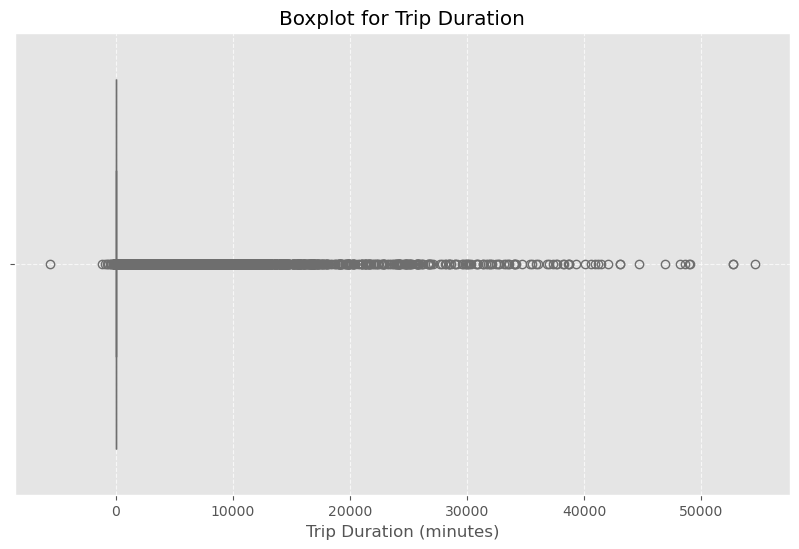

In [85]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot for the trip_duration column
sns.boxplot(x=df['trip_duration'], color='lightcoral')

# Adjust the layout and labels
plt.title('Boxplot for Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

* distribution is extremely positively skewed with significant outliers.
* I would like to review the negative durations before defining thresholds for identifying outliers.

In [94]:
df_filtered = df[df['trip_duration'] < 0]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582 entries, 24604 to 10613394
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   rideable_type       582 non-null    category      
 1   started_at          582 non-null    datetime64[ns]
 2   ended_at            582 non-null    datetime64[ns]
 3   start_station_name  180 non-null    object        
 4   start_station_id    180 non-null    Int64         
 5   end_station_name    527 non-null    object        
 6   end_station_id      527 non-null    Int64         
 7   start_lat           582 non-null    float64       
 8   start_lng           582 non-null    float64       
 9   end_lat             582 non-null    float64       
 10  end_lng             582 non-null    float64       
 11  member_casual       582 non-null    object        
 12  trip_duration       582 non-null    int32         
dtypes: Int64(2), category(1), datetime64[ns](2), f

In [99]:
df_filtered.head(200).T

,24604,41836,96224,131039,149455,156354,156443,168530,176289,203924,204664,245106,283923,283926,286060,292044,296332,303747,338935,347722,377717,415294,430581,465855,477668,482375,493091,504779,542349,568799,635184,637814,644641,653899,655769,657360,657665,662919,676120,676395,678264,681130,691868,706230,707317,707319,710650,739298,747026,760951,791788,809923,867928,886548,899637,899639,952543,1000657,1009214,1019544,1021495,1024036,1035170,1135715,1141063,1154669,1176561,1204309,1206470,1217401,1230287,1241248,1252754,1290504,1295529,1456998,1483778,1541246,1557909,1560294,1628275,1638921,1716354,1730146,1735751,1742591,1748018,1820283,1969958,1973945,1974425,1975723,1976004,2044299,2062456,2095878,2371411,2371451,2371459,2371479,2371480,2371493,2371502,2371506,2371508,2371521,2371530,2371532,2371534,2371536,2371539,2371540,2371541,2371545,2371546,2371547,2371548,2371549,2371551,2371552,2371555,2371556,2371557,2371558,2371559,2371560,2371562,2371564,2371569,2371571,2677446,2798718,2809299,2813266,2897925,2900531,2901430,3084617,3125944,3216837,3242687,3263134,3289844,3469562,3491614,3637039,3731620,3759569,3769487,3790430,3848878,3994362,4025509,4158346,4203366,4204282,4492491,4517991,4558487,4666330,4920545,5137430,5198267,5365799,5494607,5532666,5769697,5827401,5849587,5854487,5854494,5854525,5854531,5854559,5854569,5854580,5854585,5854589,5854591,5854595,5854599,5854603,5854604,5854609,5854614,5854616,5854618,5854619,5854620,5854623,5854624,5854626,5854633,5854634,5854635,5854638,5854639,5854641,5854642,5854644
rideable_type,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,docked_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,docked_bike,docked_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,docked_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,clas

In [96]:
df_filtered.tail(50).T

,10073854,10099635,10104591,10116846,10116889,10116914,10116916,10116919,10116933,10116939,10116942,10116943,10116947,10116949,10116952,10116954,10116959,10116968,10116975,10116978,10116980,10116981,10116982,10116990,10116991,10116994,10116995,10116998,10116999,10117000,10117004,10117005,10117007,10117008,10117010,10117012,10117014,10117015,10160736,10198030,10202389,10209736,10248575,10265778,10270016,10430932,10538931,10554281,10602371,10613394
rideable_type,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,electric_bike,classic_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,classic_bike,classic_bike,classic_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike,electric_bike
started_at,2023-11-02 10:49:51,2023-11-04 09:20:47,2023-11-04 13:35:32,2023-11-05 01:26:09,2023-11-05 01:34:37,2023-11-05 01:38:25,2023-11-05 01:38:39,2023-11-05 01:38:54,2023-11-05 01:40:53,2023-11-05 01:41:47,2023-11-05 01:42:37,2023-11-05 01:42:48,2023-11-05 01:44:07,2023-11-05 01:44:33,2023-11-05 01:45:13,2023-11-05 01:45:44,2023-11-05 01:46:26,2023-11-05 01:47:54,2023-11-05 01:49:01,2023-11-05 01:49:41,2023-11-05 01:49:57,2023-11-05 01:50:08,2023-11-05 01:50:10,2023-11-05 01:52:41,2023-11-05 01:52:44,2023-11-05 01:53:36,2023-11-05 01:53:48,2023-11-05 01:54:55,2023-11-05 01:55:03,2023-11-05 01:55:32,2023-11-05 01:56:08,2023-11-05 01:56:21,2023-11-05 01:56:38,2023-11-05 01:56:47,2023-11-05 01:58:02,2023-11-05 01:58:23,2023-11-05 01:59:14,2023-11-05 01:59:36,2023-11-07 22:01:21,2023-11-10 18:59:08,2023-11-11 10:23:11,2023-11-11 16:01:42,2023-11-14 17:13:42,2023-11-15 19:31:01,2023-11-16 08:25:06,2023-12-02 14:00:51,2023-12-12 15:12:59,2023-12-13 19:24:14,2023-12-18 16:36:56,2023-12-19 18:36:02
ended_at,2023-11-02 10:25:38,2023-11-04 09:17:38,2023-11-04 13:31:06,2023-11-05 01:00:23,2023-11-05 01:02:39,2023-11-05 01:09:28,2023-11-05 01:16:28,2023-11-05 01:24:19,2023-11-05 01:03:51,2023-11-05 01:33:09,2023-11-05 01:03:03,2023-11-05 01:07:58,2023-11-05 01:14:50,2023-11-05 01:18:52,2023-11-05 01:18:11,2023-11-05 01:16:51,2023-11-05 01:06:36,2023-11-05 01:00:52,2023-11-05 01:04:04,2023-11-05 01:00:55,2023-11-05 01:05:18,2023-11-05 01:00:59,2023-11-05 01:04:56,2023-11-05 01:14:10,2023-11-05 01:01:16,2023-11-05 01:10:02,2023-11-05 01:00:37,2023-11-05 01:06:44,2023-11-05 01:31:18,2023-11-05 01:10:55,2023-11-05 01:10:59,2023-11-05 01:23:19,2023-11-05 01:23:24,2023-11-05 01:05:16,2023-11-05 01:07:05,2023-11-05 01:17:32,2023-11-05 01:06:56,2023-11-05 01:01:55,2023-11-07 21:58:27,2023-11-10 18:55:44,2023-11-11 10:13:20,2023-11-11 15:57:39,2023-11-14 17:08:27,2023-11-15 19:26:53,2023-11-16 08:23:24,2023-12-02 13:56:26,2023-12-12 15:08:43,2023-12-13 19:17:37,2023-12-18 16:33:12,2023-12-19 18:34:33
start_station_name,NaN,NaN,NaN,Columbia Rd & Belmont St NW,Massachusetts Ave & Dupont Circle NW,1st & M St NE,10th & U St NW,Wilson Blvd & Ft Myer Dr,NaN,N Lynn St & Fairfax Dr,Rhode Island & Connecticut Ave NW,14th St & Rhode Island Ave NW,11th & Kenyon St NW,10th & U St NW,10th & U St NW,14th & Irving St NW,16th & R St NW,11th & V St NW,17th St & Massachusetts Ave NW,Massachusetts Ave & Dupont Circle NW,1st & Rhode Island Ave NW,Massachusetts Ave & Dupont Circle NW,17th St & Rhode Island Ave NW,13th & U St NW,13th & U St NW,7th & S St NW,Columbia & Ontario Rd NW,8th & V St NW,NaN,Columbia Rd & Belmont St NW,Columbia Rd & Belmont St NW,11th & Clifton St NW,11th & Clifton St NW,4th & College St NW,NaN,M St & Delaware Ave NE,Clarendon Metro / Wilson Blvd & N Highland St,24th & N St NW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [97]:
df_filtered['rideable_type'].unique()

['electric_bike', 'classic_bike', 'docked_bike']
Categories (3, object): ['classic_bike', 'docked_bike', 'electric_bike']

* total of 580 trips have negative durations.
* all types of bikes and memberships are affected by negative trip durations. 
* Some of these rides have missing values for either the start or end station name (or both), and the geo-locations for these missing stations are less precise, with only 2 decimal points instead of 6. This can be a technical issue on bikes gps device. 
* Some trips have the same start and end station, indicating no actual ride occurred.
* The remaining trips, with different start and end locations, share a common factor: they occurred between 1:00 and 2:00 AM on the first days of November, which corresponds to the first Sunday of November — the day when daylight savings time ends in Washington, D.C.


In [101]:
# Drop rows from the main df where trip_duration is negative and either start_station_name or end_station_name is NaN

df = df[~((df['trip_duration'] < 0) & (df['start_station_name'].isna() | df['end_station_name'].isna()))]


In [102]:
df_filtered = df[df['trip_duration'] < 0]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 149455 to 10117015
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   rideable_type       168 non-null    category      
 1   started_at          168 non-null    datetime64[ns]
 2   ended_at            168 non-null    datetime64[ns]
 3   start_station_name  168 non-null    object        
 4   start_station_id    168 non-null    Int64         
 5   end_station_name    168 non-null    object        
 6   end_station_id      168 non-null    Int64         
 7   start_lat           168 non-null    float64       
 8   start_lng           168 non-null    float64       
 9   end_lat             168 non-null    float64       
 10  end_lng             168 non-null    float64       
 11  member_casual       168 non-null    object        
 12  trip_duration       168 non-null    int32         
dtypes: Int64(2), category(1), datetime64[ns](2), 

In [103]:
df_filtered

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
149455,classic_bike,2021-02-20 16:00:51,2021-02-20 16:00:11,14th & Belmont St NW,31119,14th & Belmont St NW,31119,38.921074,-77.031887,38.921074,-77.031887,member,-1
156354,classic_bike,2021-02-23 15:02:24,2021-02-23 15:01:53,Langston Blvd & N Woodstock St,31900,Langston Blvd & N Woodstock St,31900,38.898301,-77.118009,38.898301,-77.118009,member,-1
168530,classic_bike,2021-02-26 11:15:59,2021-02-26 11:15:08,N Veitch St & Key Blvd,31028,N Veitch St & Key Blvd,31028,38.893237,-77.086063,38.893237,-77.086063,member,-1
204664,classic_bike,2021-03-07 17:45:21,2021-03-07 17:44:21,Gravelly Point,31064,Gravelly Point,31064,38.865029,-77.039511,38.865029,-77.039511,member,-1
245106,classic_bike,2021-03-14 13:36:13,2021-03-14 13:35:26,11th & O St NW,31286,11th & O St NW,31286,38.908430,-77.027140,38.908430,-77.027140,member,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10117007,classic_bike,2023-11-05 01:56:38,2023-11-05 01:23:24,11th & Clifton St NW,31136,Maine Ave & 7th St SW,31609,38.922324,-77.027086,38.878694,-77.023054,casual,-33
10117008,electric_bike,2023-11-05 01:56:47,2023-11-05 01:05:16,4th & College St NW,31138,Georgia Ave & Morton St NW,31419,38.921184,-77.018027,38.932128,-77.023500,member,-52
10117012,classic_bike,2023-11-05 01:58:23,2023-11-05 01:17:32,M St & Delaware Ave NE,31627,7th & S St NW,31130,38.905691,-77.003201,38.914174,-77.021595,casual,-41
10117014,classic_bike,2023-11-05 01:59:14,2023-11-05 01:06:56,Clarendon Metro / Wilson Blvd & N Highland St,31022,Langston Blvd & N Scott St,31080,38.887010,-77.095257,38.897612,-77.080851,casual,-52
